In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
%matplotlib notebook
import scipy
from scipy import stats

from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

## Plot out some quick Stats

In [16]:
# Create a metadata describe frame for the Reservoir data 

station_id = []; datemin = []; datemax = []; datamean = []
datamedian = []; datamax= []; datamin=[]


for file in os.listdir(os.path.join("..", "Data/Processed")):
    data = pd.read_csv(os.path.join("..", "Data/Processed", file), parse_dates=['date'])
    data = data.replace(-66577, np.nan)
    
    station_id.append(file.split(".")[0])
    datemin.append(data['date'].min())
    datemax.append(data['date'].max())
    datamean.append(data['data'].describe()[1])
    datamedian.append(data['data'].describe()[5])
    datamin.append(data['data'].describe()[3])
    datamax.append(data['data'].describe()[7])
    
data_describe = pd.DataFrame({'station_id':station_id, 
              "date_min":datemin,
              "date_max":datemax ,
              "mean_WL":datamean ,
              "median_WL": datamedian,
              "min_WL":datamin ,
              "max_WL":datamax           
             })

data_describe.to_csv("data_describe_stats.csv")

data_describe.head()

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,station_id,date_min,date_max,mean_WL,median_WL,min_WL,max_WL
0,WL_EDD00214,2018-12-31 22:09:00,2022-09-13 19:04:00,1477.708254,1470.0,1315.0,1907.0
1,WL_EDD00CC6,2018-12-31 22:09:00,2022-09-13 19:04:00,854.019944,819.0,-125738.0,131071.0
2,WL_EDD01162,2022-04-26 22:09:00,2022-09-13 19:04:00,-216.985699,-217.0,-237.0,-190.0
3,WL_EDD01FB0,2021-03-16 19:09:00,2021-07-27 18:04:00,2373.487317,2032.0,1926.0,4568.0
4,WL_EDD024F8,2018-12-31 22:09:00,2022-09-13 19:04:00,38160.316775,38135.0,-92938.0,59639.0


## Import Data Files and resample to Daily 

In [22]:
daily_dic = {}

for file in os.listdir(os.path.join("..", "Data/Processed")):
    print(file)
    data = pd.read_csv(os.path.join("..", "Data/Processed", file), parse_dates=['date'])
    data = data.replace(-66577, np.nan)
    
    # Remove outliers based on a certain number of standard deviations from the mean 
    # Probably could use a more advanced filtering method later if need
    STDs = 3
    data = data[((data['data'] - data['data'].mean()) / data['data'].std()).abs() < STDs]
    
    # Convert from decimal feet to ft. 
    data['data'] = data['data']/100
    
    #resample data to daily 
    data = data.set_index("date")
    data_daily =  data.resample('D').mean() 
    
    # record daily files in a dictionary of dataframes
    daily_dic[file] = data_daily
    
daily_dic.keys()

# FUP WL_EDD05CBA.csv

WL_EDD00214.csv
WL_EDD00CC6.csv


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


WL_EDD01162.csv
WL_EDD01FB0.csv
WL_EDD024F8.csv
WL_EDD02A2A.csv
WL_EDD0378E.csv
WL_EDD0395C.csv
WL_EDD0411E.csv
WL_EDD04FCC.csv
WL_EDD05268.csv
WL_EDD05CBA.csv
WL_EDD067F2.csv
WL_EDD06920.csv
WL_EDD07484.csv
WL_EDD07A56.csv
WL_EDD08400.csv
WL_EDD08AD2.csv
WL_EDD099A4.csv
WL_EDD0A2EC.csv
WL_EDD0AC3E.csv
WL_EDD0B19A.csv
WL_EDD0BF48.csv
WL_EDD0C70A.csv
WL_EDD0C9D8.csv
WL_EDD0D47C.csv
WL_EDD11398.csv


dict_keys(['WL_EDD00214.csv', 'WL_EDD00CC6.csv', 'WL_EDD01162.csv', 'WL_EDD01FB0.csv', 'WL_EDD024F8.csv', 'WL_EDD02A2A.csv', 'WL_EDD0378E.csv', 'WL_EDD0395C.csv', 'WL_EDD0411E.csv', 'WL_EDD04FCC.csv', 'WL_EDD05268.csv', 'WL_EDD05CBA.csv', 'WL_EDD067F2.csv', 'WL_EDD06920.csv', 'WL_EDD07484.csv', 'WL_EDD07A56.csv', 'WL_EDD08400.csv', 'WL_EDD08AD2.csv', 'WL_EDD099A4.csv', 'WL_EDD0A2EC.csv', 'WL_EDD0AC3E.csv', 'WL_EDD0B19A.csv', 'WL_EDD0BF48.csv', 'WL_EDD0C70A.csv', 'WL_EDD0C9D8.csv', 'WL_EDD0D47C.csv', 'WL_EDD11398.csv'])

In [23]:
## Import metadata
Station_Meta = pd.read_csv("Gauged_reservoirs_META.csv", index_col=0)
Station_Meta.head()

,batt_1w_slope,batt_alert,batt_alert_off,batt_alert_on,dlnrid,level_alert,level_alert_off,level_alert_on,name,id
0,5.056549e-08,0,11.7,11.5,KA-0099,0,17.0,19.0,Waita,EDD00214
1,1.113613e-06,0,11.7,11.5,KA-0010,1,11.0,12.0,Waiakalua,EDD00CC6
2,0.000000e+00,0,11.7,11.5,MA-0073,0,13.0,14.0,HC&S #24,EDD01162
3,0.000000e+00,0,11.7,11.5,MA-0093,0,34.4,35.4,Kaupakalua,EDD01FB0
4,6.511962e-08,0,11.7,11.5,OA-0154,0,393.0,394.0,Nuuanu No 1,EDD024F8


# RAINDATA
using statewide data download from HCDP, its actually a total pain. The data formattng is strange, and station metadata is inconsistent. Oh well...

In [24]:
#Concat rain data 

Datadic = {}
metadata_dic = {}


raindatapath = "Data/External_data/Precip/2018-2022_station_data"

for year in os.listdir(os.path.join("..", raindatapath)):
    for month in os.listdir(os.path.join("..", raindatapath, year)):
        file = os.listdir(os.path.join("..", raindatapath, year, month))
        
        # Process into a better format where columns are individual stations and y axis is date
        data = pd.read_csv(os.path.join("..", raindatapath, year, month, file[0]))
        
        # Extract a separaate dataframe of metadata 
        data_metaonly = data[['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id', 'SMART_NODE_RF.id']]
        metadata_dic[file[0]]  = data_metaonly
        
        
        data.drop([ 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
               'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
               'SMART_NODE_RF.id'], axis=1, inplace=True)

        data = data.set_index("SKN", drop=True)
        data = data.transpose()

        data = data.reset_index()
        data['index'] = data['index'].astype(str)

        data['index'] = data['index'].apply(lambda x: x[1:])  # Pull out the X
        data['index'] = pd.to_datetime(data['index'], yearfirst=True)  # .dt.strftime("%Y-%m-%d")
        data.set_index("index", inplace=True)
        data.columns.name = None   # drop the wierd double axis label 
        
        Datadic[file[0]]  = data 
        
# Produce the rainfall dataframe 
RainData = pd.concat(Datadic.values(), sort=True)  
# Produce the metadataframe 
RainData_Meta = pd.concat(metadata_dic.values(), sort=True) 

# SO herees a problem, NO field in the metadata is unique, meaning there is some f-up in the station IDentifiers.  Creating a *hoprefully* unique ID with a couple fields
RainData_Meta['UID'] = RainData_Meta['LAT'].map('{:.6f}'.format).astype(str)+"_"+RainData_Meta['LON'].map('{:.6f}'.format).astype(str)
RainData_Meta.drop_duplicates(subset='UID', inplace=True)     # Hoping to limit to to non-duplicate stations    

# genearate near table outside in Arc 
RainData_Meta["SKN"] = RainData_Meta["SKN"].astype(str)+"_R"   # First make Arc read it as a string 
RainData_Meta.to_csv('RainData_Meta_v2.csv')
# NOW Open in Arc and do a "Point Distance" to generate a near table for each of the reservoirs and each rain location point
# Then need to filter pertinant fields and so a table join based on the table FIDs
RainData_Meta.head()

,ELEV.m.,Island,LAT,LON,NCEI.id,NESDIS.id,NWS.id,Network,Observer,SCAN.id,SKN,SMART_NODE_RF.id,Station.Name,UID
0,957.0,BI,19.108900,-155.746700,USC00512566,NaN,NaN,COOP,COOP,NaN,2.1_R,NaN,KAHUKU MAUKA,19.108900_-155.746700
1,647.0,BI,19.107780,-155.789440,USC00518652,NaN,NaN,COOP,COOP,NaN,2.32_R,NaN,SOUTH KONA 2 2.32,19.107780_-155.789440
2,280.0,BI,19.186302,-155.886763,USC00516304,NaN,NaN,COOP,COOP,NaN,2.34_R,NaN,MILOLII 2.34,19.186302_-155.886763
3,533.0,BI,19.144720,-155.849440,USC00513376,NaN,NaN,COOP,COOP,NaN,2.36_R,NaN,KAPUA 2.36,19.144720_-155.849440
4,1273.0,BI,19.135000,-155.747000,US1HIHI0035,NaN,NaN,CoCoRaHS,HAWAIIAN OCEAN VIEW 4.7 NNE,NaN,3.22_R,NaN,HAWAIIAN OCEAN VIEW 4.7 NNE,19.135000_-155.747000


In [25]:
# Find the nearest rainfall stations to each of the gauges

n = 5   # The number of rain stations to use
near_table = pd.read_csv(os.path.join("..", "Data/External_data/Precip/2018-2022_station_data_GIS/Reservoirs_Precip_Near_table_V2.csv"))

neartable_N = pd.DataFrame(columns=near_table.columns)

for i in near_table['id'].unique():
    temptable = near_table[near_table['id'] == i]  # For each of the reservoits
    
    temptable = temptable.sort_values('DISTANCE')  # find the closest stations
    temptable = temptable.iloc[0:n]             # select only the n closest stations 
    neartable_N = neartable_N.append(temptable)               # Create dataframe of only the n closest stations 
    
neartable_N.head()

,OBJECTID,INPUT_FID,NEAR_FID,DISTANCE,FID,name,id,FID_1,Island,SKN,Station_Na,UID,UID_X,UID_Y
458,459,0,391,1327.753383,0,Waita,EDD00214,391,KA,936.0_R,KOLOA 936,21.906865_-159.462206,-159.462206,21.906865
455,456,0,400,2821.076687,0,Waita,EDD00214,400,KA,992.1_R,Omao,21.907101_-159.476800,-159.476800,21.907101
456,457,0,393,2962.888650,0,Waita,EDD00214,393,KA,941.1_R,MAHAULEPU 941.1,21.901030_-159.422207,-159.422207,21.901030
457,458,0,392,3357.765380,0,Waita,EDD00214,392,KA,940.2_R,KOLOA 2.1 SSE,21.878800_-159.451800,-159.451800,21.878800
454,455,0,481,3600.799018,0,Waita,EDD00214,481,KA,940.3_R,POIPU,21.882800_-159.429000,-159.429000,21.882800


# Create plots of reservoir level and rainfall 

<IPython.core.display.Javascript object>


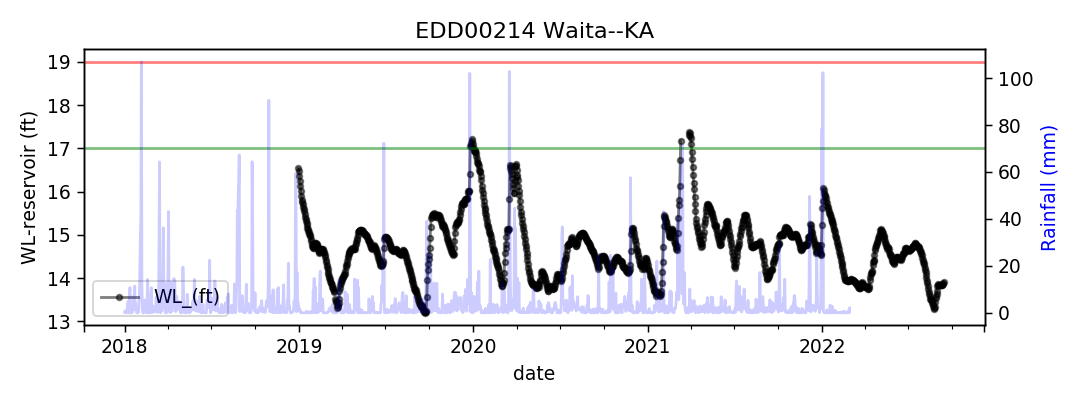

<IPython.core.display.Javascript object>


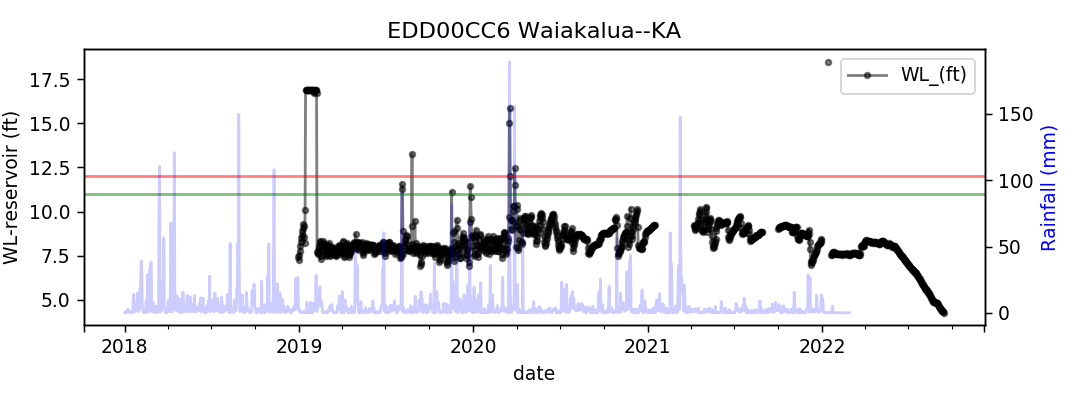

<IPython.core.display.Javascript object>


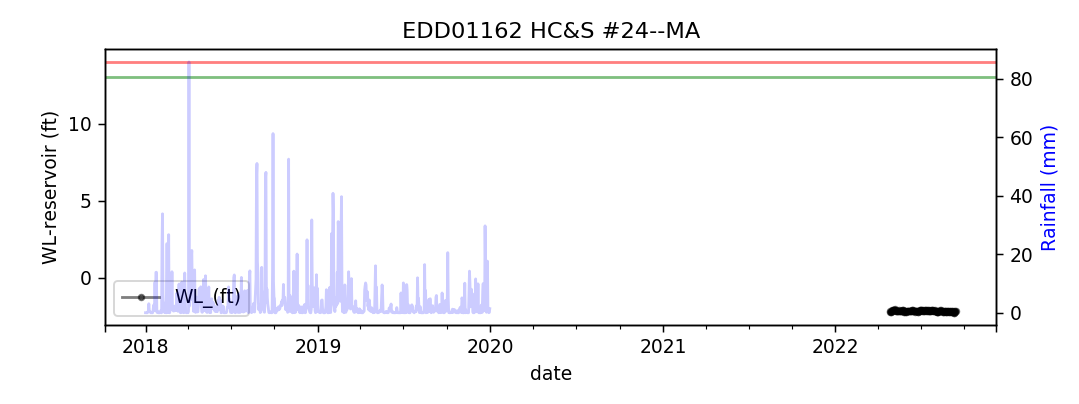

<IPython.core.display.Javascript object>


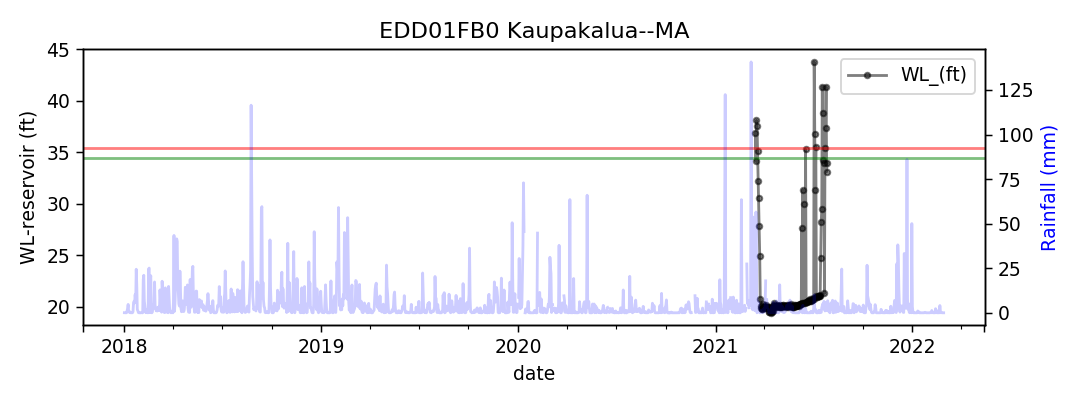

<IPython.core.display.Javascript object>


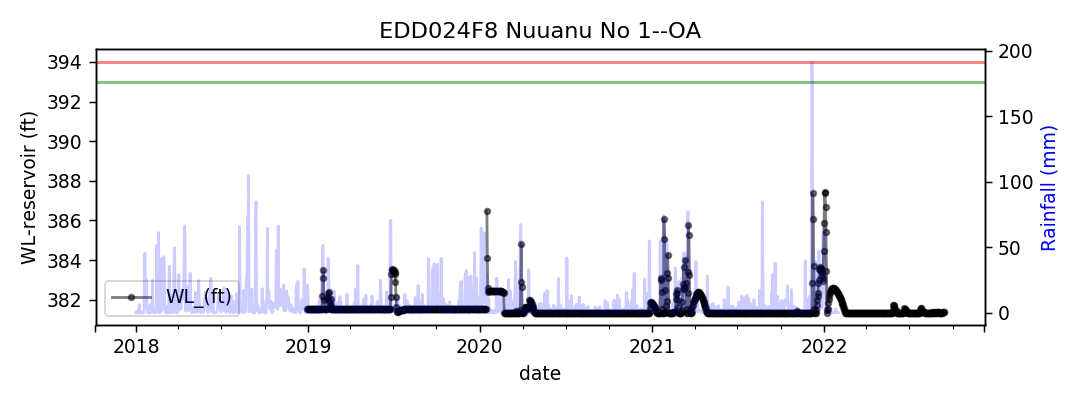

<IPython.core.display.Javascript object>


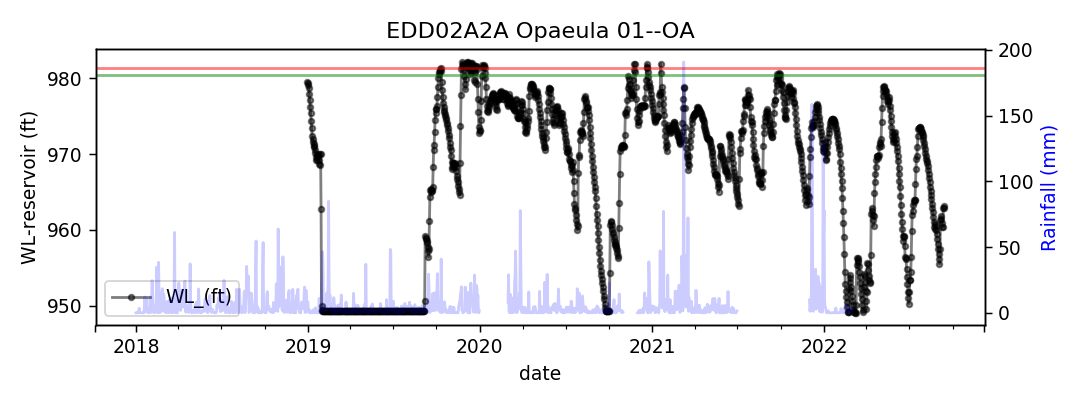

<IPython.core.display.Javascript object>


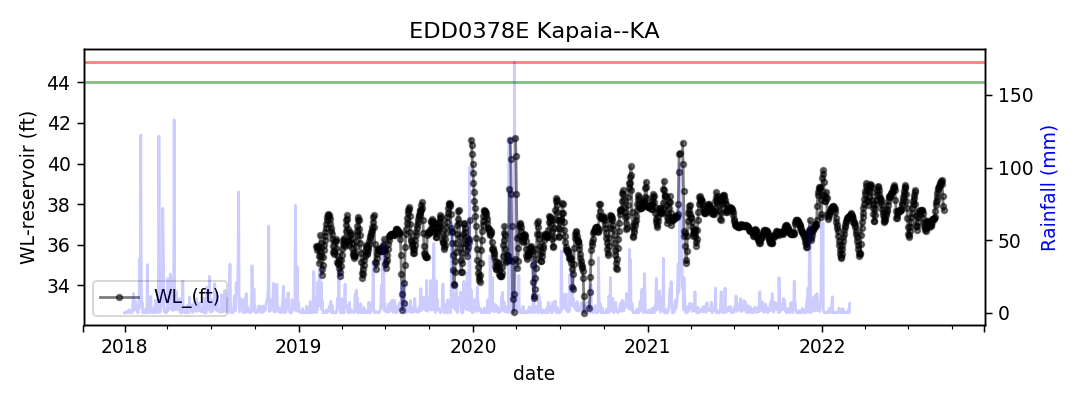

<IPython.core.display.Javascript object>


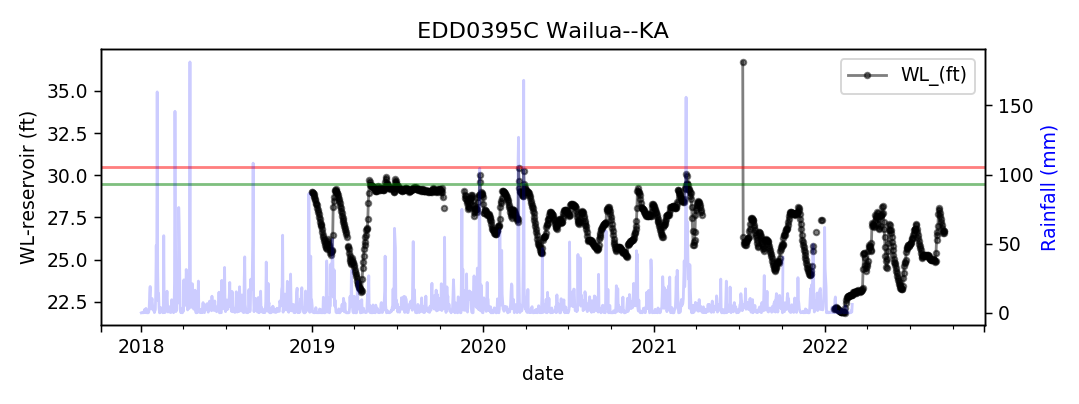

<IPython.core.display.Javascript object>


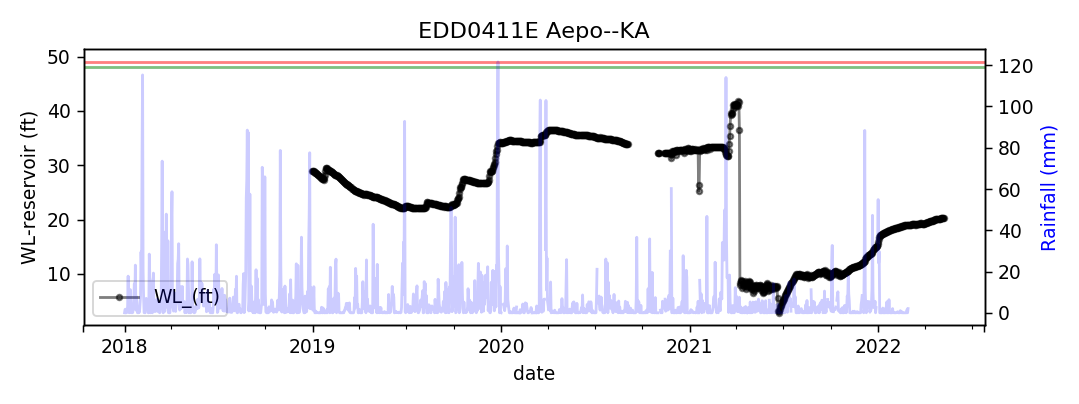

<IPython.core.display.Javascript object>


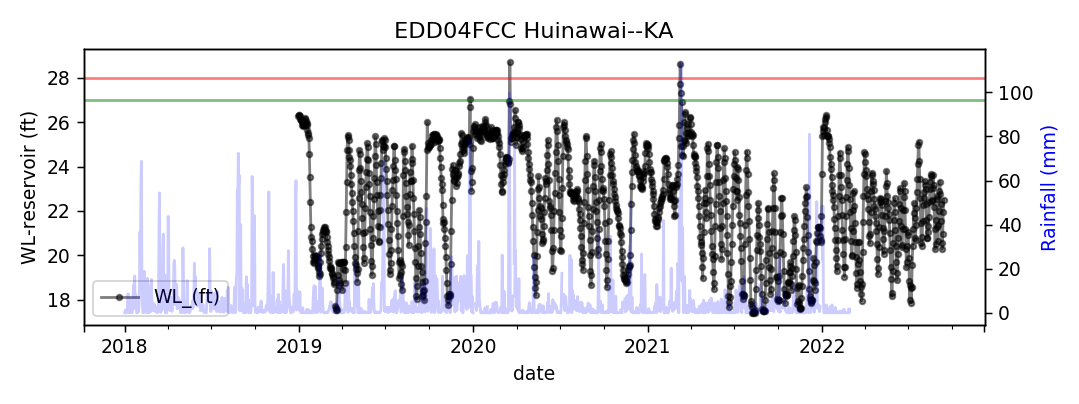

<IPython.core.display.Javascript object>


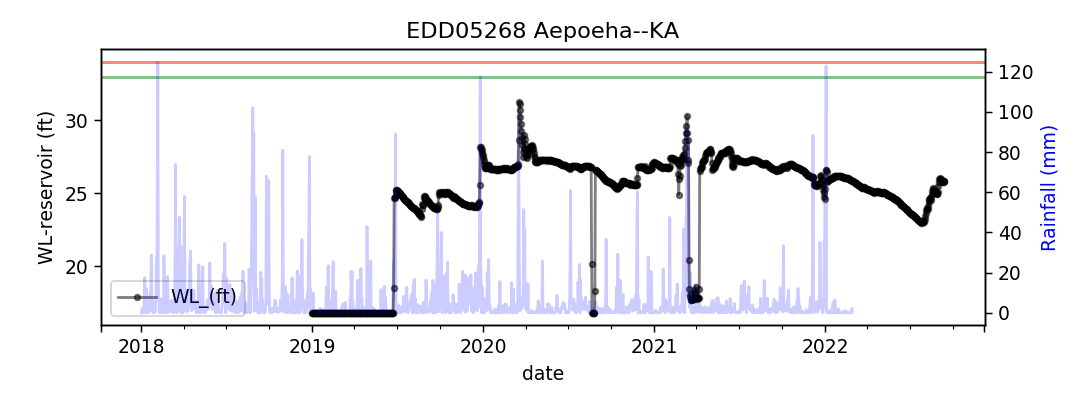

<IPython.core.display.Javascript object>


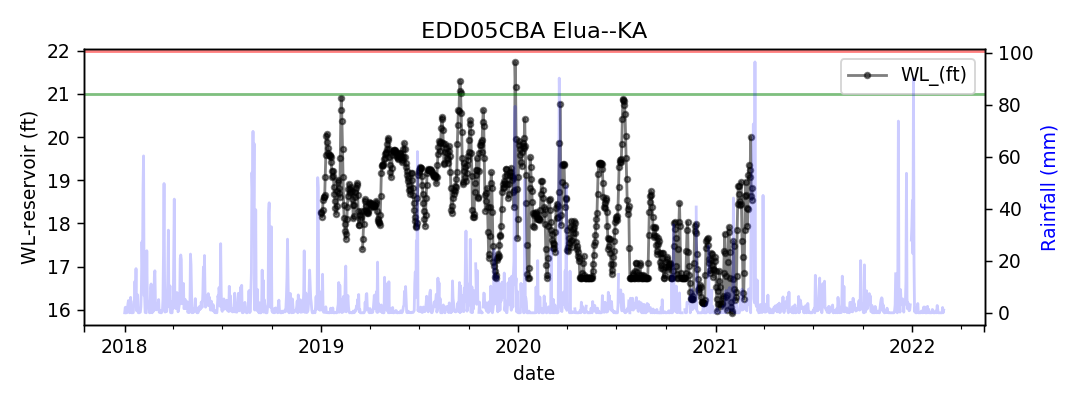

<IPython.core.display.Javascript object>


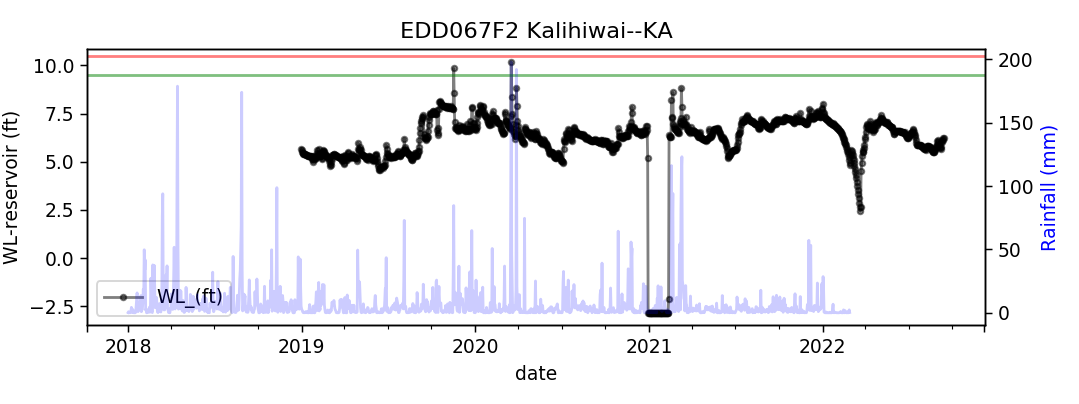

<IPython.core.display.Javascript object>


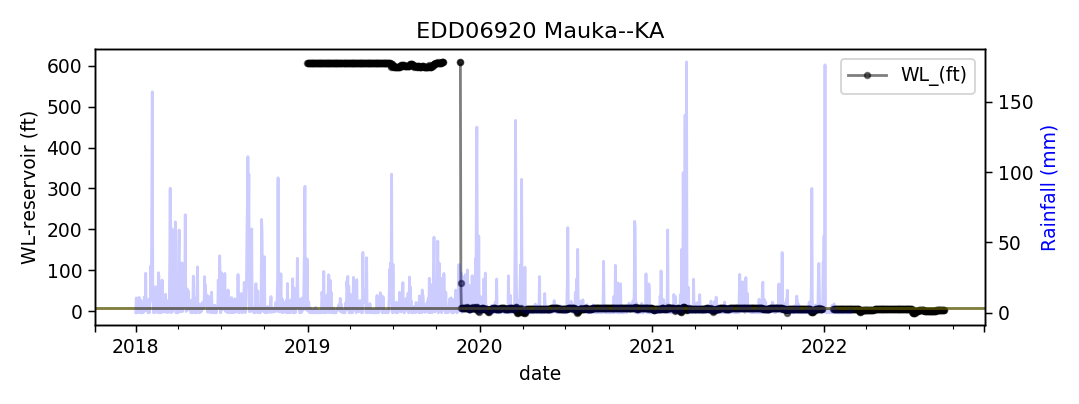

<IPython.core.display.Javascript object>


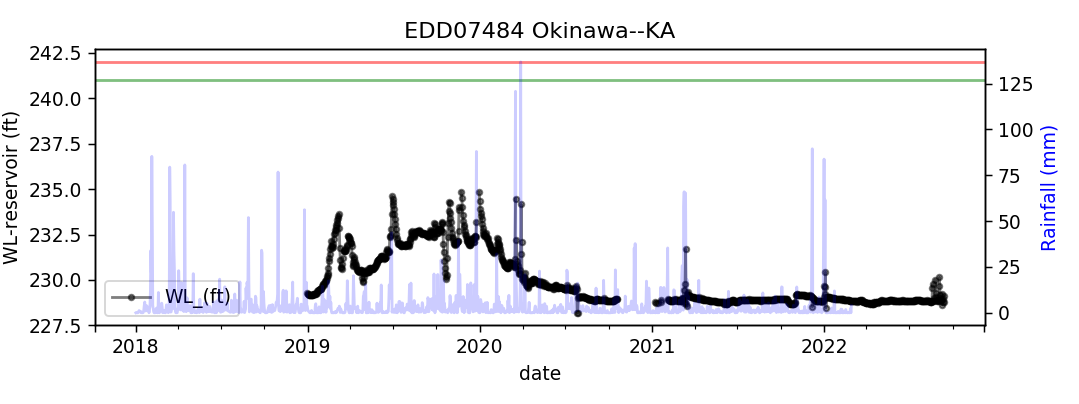

<IPython.core.display.Javascript object>


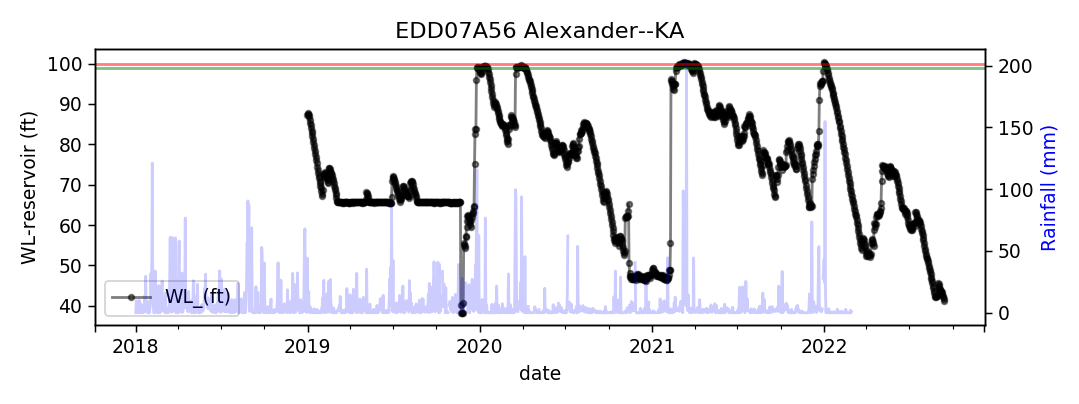

<IPython.core.display.Javascript object>


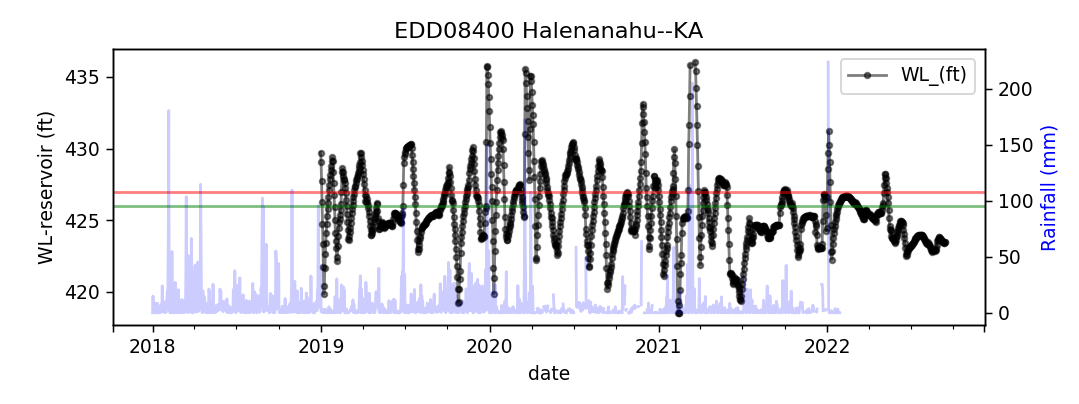

<IPython.core.display.Javascript object>


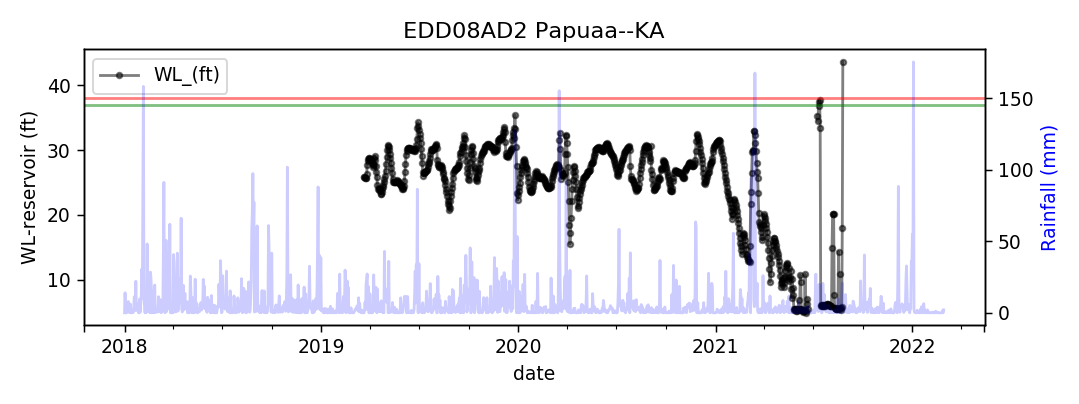

<IPython.core.display.Javascript object>


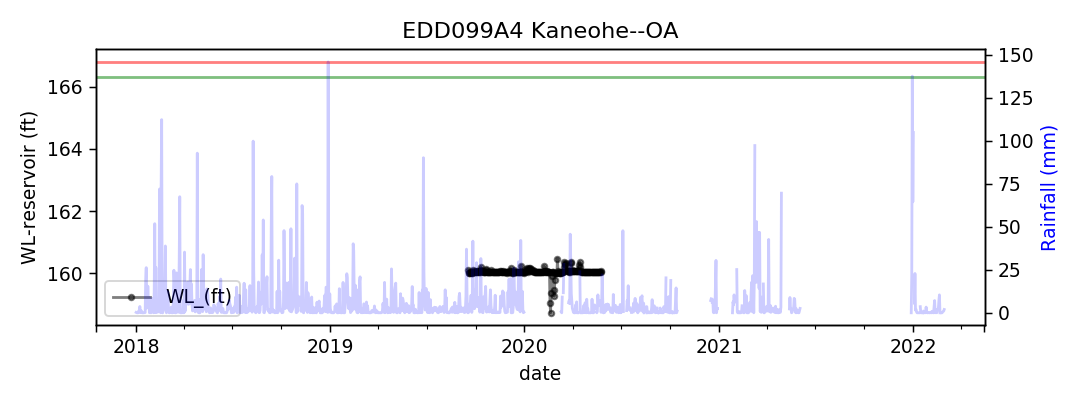

<IPython.core.display.Javascript object>


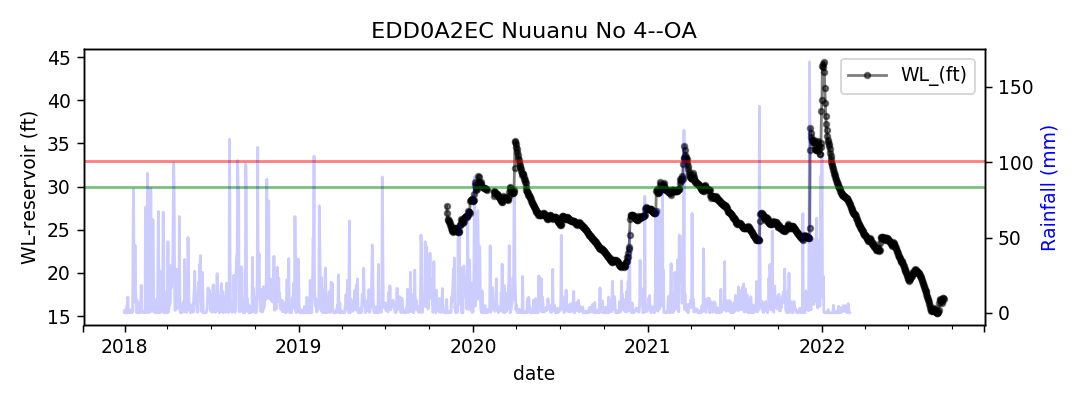

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


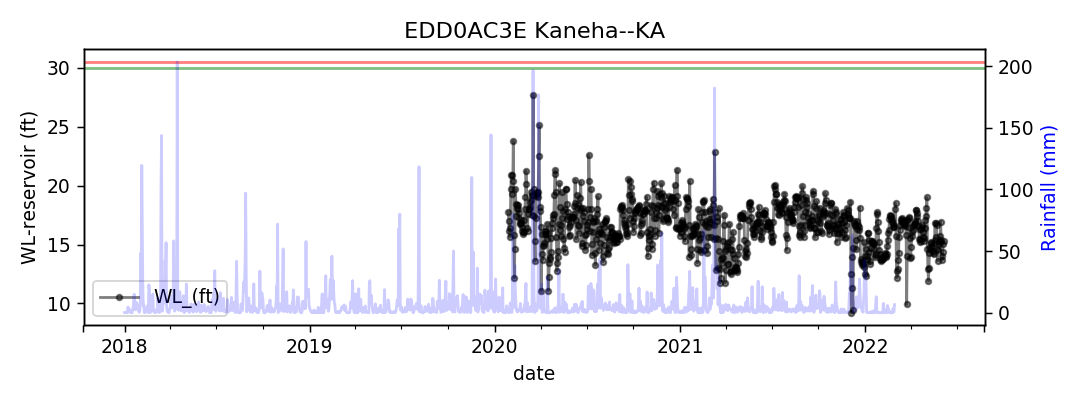

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


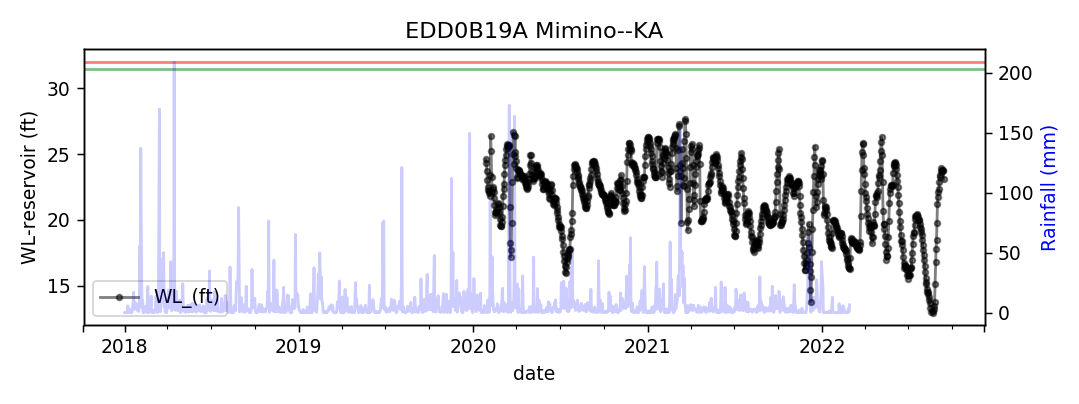

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


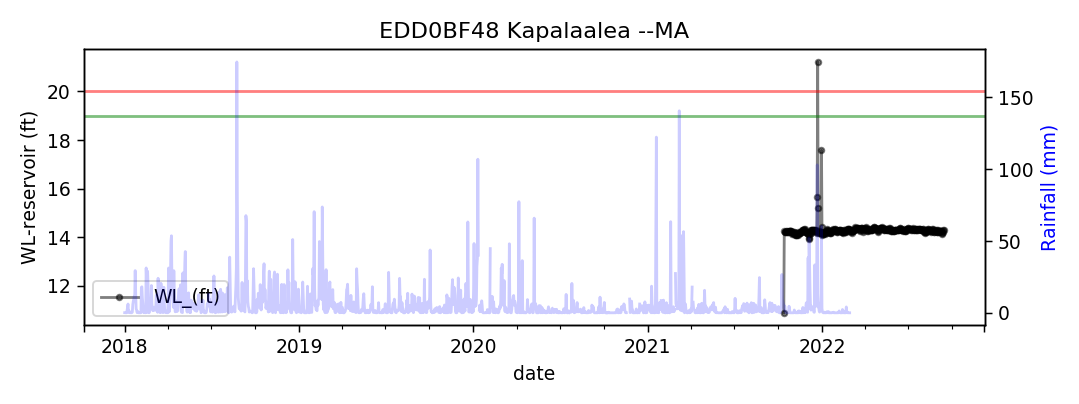

<IPython.core.display.Javascript object>


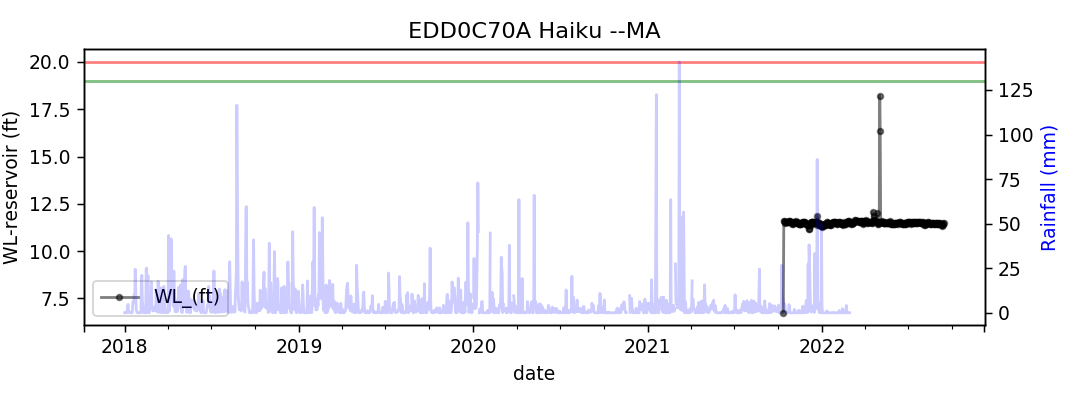

<IPython.core.display.Javascript object>


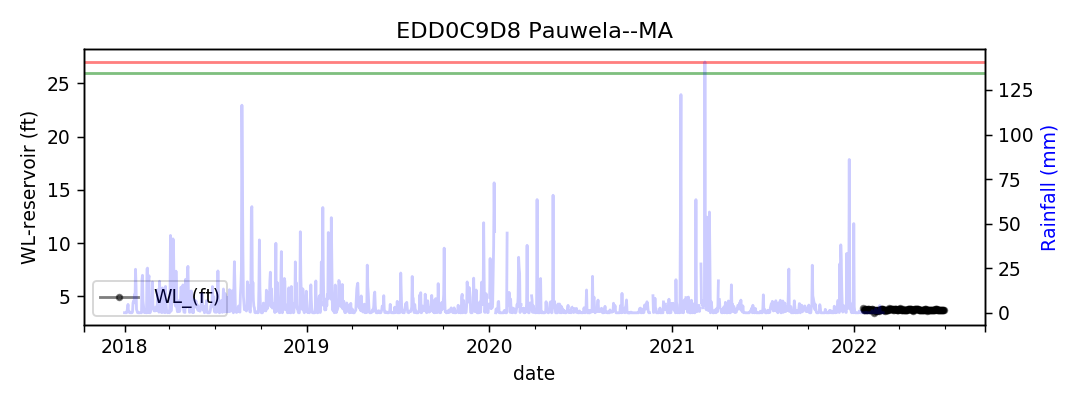

<IPython.core.display.Javascript object>


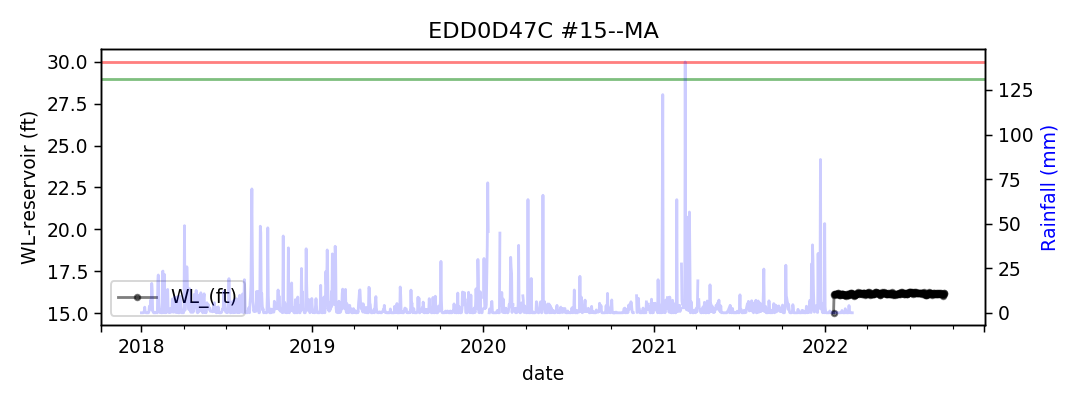

<IPython.core.display.Javascript object>


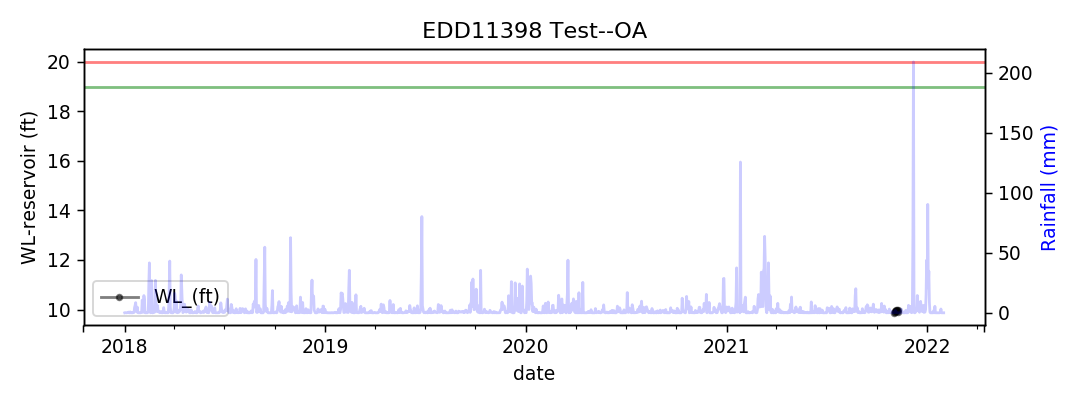

In [30]:

smalldic = {key: daily_dic[key] for key in ['WL_EDD00214.csv', 'WL_EDD00CC6.csv', 'WL_EDD01FB0.csv', 'WL_EDD024F8.csv']}   # For testing 

for i in daily_dic.keys():  #daily_dic.keys(): 
    #print(i)

    stat_id = i[3:-4]
    isla = Station_Meta['dlnrid'][Station_Meta['id'] == stat_id].values[0].split('-')[0]
    
    fig, ax = plt.subplots(figsize=(8,3))
    daily_dic[i].plot(y='data', ax=ax, marker=".", color='k', alpha=0.5, label="WL_(ft)")
    
    # Add the lever alert lines
    Level_alert_on = Station_Meta['level_alert_on'][Station_Meta['id'] == stat_id].values[0]
    plt.axhline(y=Level_alert_on, color='r', linestyle='-', alpha = 0.5)   
    Level_alert_off = Station_Meta['level_alert_off'][Station_Meta['id'] == stat_id].values[0]
    plt.axhline(y=Level_alert_off, color='g', linestyle='-', alpha = 0.5)
    
    
    # Add rainfall 
    
    # Create average rainfall from nearest N stations 
    ax2=ax.twinx()
    nearest_SKN_table = neartable_N[neartable_N['id'] == stat_id]     # Reference the nearest SKN stations for rainfall 
    # list nearest 5 skns
    nearest5skns = list(nearest_SKN_table['SKN'])                      # Pull out the SKN vales from the dataframe 
    nearest5skns = list(map(lambda x: x.split("_")[0], nearest5skns))  # Quick list function map to pull of the "_R" from each SKN
    nearest5skns = list(map(lambda x: float(x), nearest5skns))  # Quick list function map to turn values back into floats
    rain_datatoplot_5 = RainData[nearest5skns]     # make it a single dataframe 
    rain_datatoplot_5_mean = rain_datatoplot_5.mean(axis=1)    # calculate the average rainfall over all N stations 
    
    
    # Find the nearest SKN 
    nearest_SKN_table_min = nearest_SKN_table[nearest_SKN_table['DISTANCE'] == nearest_SKN_table['DISTANCE'].min()]
    nearest_SKN = nearest_SKN_table_min['SKN'].values[0]
    nearest_SKN_numeric = float(nearest_SKN.split("_")[0])
    rain_datatoplot = RainData[nearest_SKN_numeric]

    
    # FOR JUST THE NEAREST STATION 
    #rain_datatoplot.plot(ax=ax2, color='b', alpha=0.2)
    
    
    # FOR THE NEAREST N STATIONS
    rain_datatoplot_5_mean.plot(ax=ax2, color='b', alpha=0.2)
    
       
    plt.title(stat_id +" "+ "{}".format(Station_Meta['name'][Station_Meta['id'] == stat_id].values[0])+"--"+isla)
    ax2.set_ylabel('Rainfall (mm)', color='b')
    ax.set_ylabel('WL-reservoir (ft)', color='k')
    plt.tight_layout()
    
    
    MergeFrame = daily_dic[i].merge(rain_datatoplot_5_mean.to_frame(), left_index=True, right_index=True, how='inner')
    MergeFrame.to_csv(os.path.join("..", "Brian_testing/Merged_DataFrames", "Merged_{}".format(i)))

### Notes
Some manual analysis of these graphs: 
- it looks like each reservoir has different responses, some dont seem to respond to the rain some do.
- Some seem to repond a little sooner, within a day, some show a clear day lag. 

In [70]:
import csv

levels = pd.DataFrame(columns = ['above', 'station', 'index', 'level_alert']) # add column for date
header = ['above', 'station', 'index']

with open('levels.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    # make station each different data frame
    for station, off, on in zip(Station_Meta['name'], Station_Meta['level_alert_off'], Station_Meta['level_alert_on']):
        for index in rain_datatoplot_5_mean: # rain level change to reservoir level
            if index > off and index < on:
                print("Above Off Index", station, index)
                indexoff = "Above Off Index", station, index, off
                writer.writerow(indexoff)
                levels.append(["Above Off Index", station, index])
            if index > on:
                print("Above On Index", station, index)
                indexon = "Above On Index", station, index, on
                writer.writerow(indexon)
                levels.append(["Above On Index", station, index])

Above Off Index Waita 18.123314949837603
Above Off Index Waita 17.6121937189769
Above On Index Waita 26.74364659790052
Above On Index Waita 23.6893998613414
Above On Index Waita 59.0528255323791
Above On Index Waita 22.960875074433055
Above On Index Waita 45.02267369789497
Above On Index Waita 34.539082189752975
Above On Index Waita 32.22649555218371
Above On Index Waita 26.4405175406852
Above On Index Waita 53.35873921257477
Above On Index Waita 30.818876042233224
Above Off Index Waita 17.32028594828652
Above On Index Waita 36.25796834065102
Above On Index Waita 22.308766299411126
Above On Index Waita 20.359682912118096
Above Off Index Waita 17.87154852841752
Above On Index Waita 28.53237893400246
Above On Index Waita 24.3871991591653
Above On Index Waita 19.431115179919807
Above Off Index Waita 17.21536221175608
Above On Index Waita 50.50845956398156
Above On Index Waita 19.507721032606117
Above On Index Waita 140.716
Above On Index Waita 22.9921626175131
Above On Index Waita 53.6570

Above On Index Waiakalua 12.101870607200144
Above On Index HC&S #24 18.123314949837603
Above On Index HC&S #24 17.6121937189769
Above On Index HC&S #24 15.88063066434336
Above Off Index HC&S #24 13.324838197209067
Above On Index HC&S #24 15.481323304510202
Above On Index HC&S #24 16.61627620820274
Above On Index HC&S #24 26.74364659790052
Above On Index HC&S #24 14.585690872338194
Above On Index HC&S #24 23.6893998613414
Above On Index HC&S #24 59.0528255323791
Above On Index HC&S #24 22.960875074433055
Above On Index HC&S #24 45.02267369789497
Above On Index HC&S #24 34.539082189752975
Above On Index HC&S #24 32.22649555218371
Above On Index HC&S #24 26.4405175406852
Above On Index HC&S #24 53.35873921257477
Above On Index HC&S #24 30.818876042233224
Above On Index HC&S #24 15.587193270389825
Above On Index HC&S #24 17.32028594828652
Above On Index HC&S #24 14.188687151947988
Above On Index HC&S #24 36.25796834065102
Above On Index HC&S #24 22.308766299411126
Above On Index HC&S #24 2

Above Off Index Wailua 29.57399999999995
Above On Index Wailua 33.27300000000005
Above On Index Wailua 85.99399999999994
Above On Index Wailua 50.03599999999995
Above On Index Wailua 37.8459999999998
Above On Index Wailua 63.5
Above On Index Wailua 65.9380000000001
Above On Index Wailua 44.7040000000001
Above On Index Wailua 31.14000000000005
Above Off Index Wailua 30.4444989712352
Above On Index Wailua 37.338
Above On Index Wailua 72.898
Above On Index Wailua 45.57167205906825
Above On Index Wailua 43.380223150258416
Above On Index Wailua 41.4671151561006
Above On Index Wailua 39.915799216910884
Above On Index Wailua 34.334807653874414
Above On Index Wailua 38.98485627949698
Above On Index Wailua 58.376793039988456
Above On Index Wailua 59.538554754891535
Above On Index Wailua 40.88230040847888
Above On Index Wailua 116.44465657877592
Above On Index Wailua 76.79799565958595
Above On Index Wailua 35.0733457237999
Above On Index Wailua 45.4654278582531
Above On Index Aepo 59.05282553237

Above On Index Kalihiwai 30.818876042233224
Above On Index Kalihiwai 15.587193270389825
Above Off Index Kalihiwai 10.355919417821713
Above On Index Kalihiwai 17.32028594828652
Above On Index Kalihiwai 11.18331862213994
Above On Index Kalihiwai 10.6932306238429
Above On Index Kalihiwai 14.188687151947988
Above On Index Kalihiwai 12.17790487875512
Above Off Index Kalihiwai 10.124061263743139
Above On Index Kalihiwai 36.25796834065102
Above On Index Kalihiwai 22.308766299411126
Above On Index Kalihiwai 12.610133398705063
Above On Index Kalihiwai 20.359682912118096
Above Off Index Kalihiwai 9.744412911364424
Above On Index Kalihiwai 16.35526256679145
Above Off Index Kalihiwai 10.01400462515891
Above On Index Kalihiwai 11.272122012452089
Above Off Index Kalihiwai 10.427460291687341
Above On Index Kalihiwai 15.67813484233479
Above On Index Kalihiwai 17.87154852841752
Above Off Index Kalihiwai 9.511089900849566
Above On Index Kalihiwai 28.53237893400246
Above On Index Kalihiwai 24.38719915916

Above On Index Mauka 42.0640615724006
Above On Index Mauka 13.462158203125
Above On Index Mauka 56.529931648437504
Above On Index Mauka 28.31700000000005
Above On Index Mauka 17.916
Above Off Index Mauka 7.366
Above On Index Mauka 15.6748249469862
Above Off Index Mauka 7.11199999999998
Above On Index Mauka 8.81366233671328
Above Off Index Mauka 7.039543434465833
Above On Index Mauka 63.459826140021
Above On Index Mauka 27.37727793159485
Above On Index Mauka 26.674
Above On Index Mauka 9.50342721523871
Above On Index Mauka 8.12800000000004
Above On Index Mauka 10.0624372973925
Above Off Index Mauka 7.019964169938641
Above On Index Mauka 11.322000000000006
Above On Index Mauka 24.528
Above On Index Mauka 18.5421142578125
Above On Index Mauka 55.85
Above On Index Mauka 122.388302937255
Above Off Index Mauka 7.216999999999915
Above On Index Mauka 8.498000000000115
Above On Index Mauka 27.4319999999999
Above On Index Mauka 38.1
Above On Index Mauka 29.57399999999995
Above On Index Mauka 13.

Above On Index Haiku  26.74364659790052
Above On Index Haiku  23.6893998613414
Above On Index Haiku  59.0528255323791
Above On Index Haiku  22.960875074433055
Above On Index Haiku  45.02267369789497
Above On Index Haiku  34.539082189752975
Above On Index Haiku  32.22649555218371
Above On Index Haiku  26.4405175406852
Above On Index Haiku  53.35873921257477
Above On Index Haiku  30.818876042233224
Above On Index Haiku  36.25796834065102
Above On Index Haiku  22.308766299411126
Above On Index Haiku  20.359682912118096
Above On Index Haiku  28.53237893400246
Above On Index Haiku  24.3871991591653
Above Off Index Haiku  19.431115179919807
Above On Index Haiku  50.50845956398156
Above Off Index Haiku  19.507721032606117
Above On Index Haiku  140.716
Above On Index Haiku  22.9921626175131
Above On Index Haiku  53.6570861486178
Above On Index Haiku  42.0640615724006
Above On Index Haiku  56.529931648437504
Above On Index Haiku  28.31700000000005
Above On Index Haiku  63.459826140021
Above On 

In [66]:
print(levels)

Empty DataFrame
Columns: [above, station, index]
Index: []


In [ ]:
print(stat_)